In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [16]:
import os
from PIL import Image
import itertools

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print('Modules Loaded')

Modules Loaded


In [17]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
df = pd.concat([FSeries, LSeries], axis=1)
df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
...,...,...
3870,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3871,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3872,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3873,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral


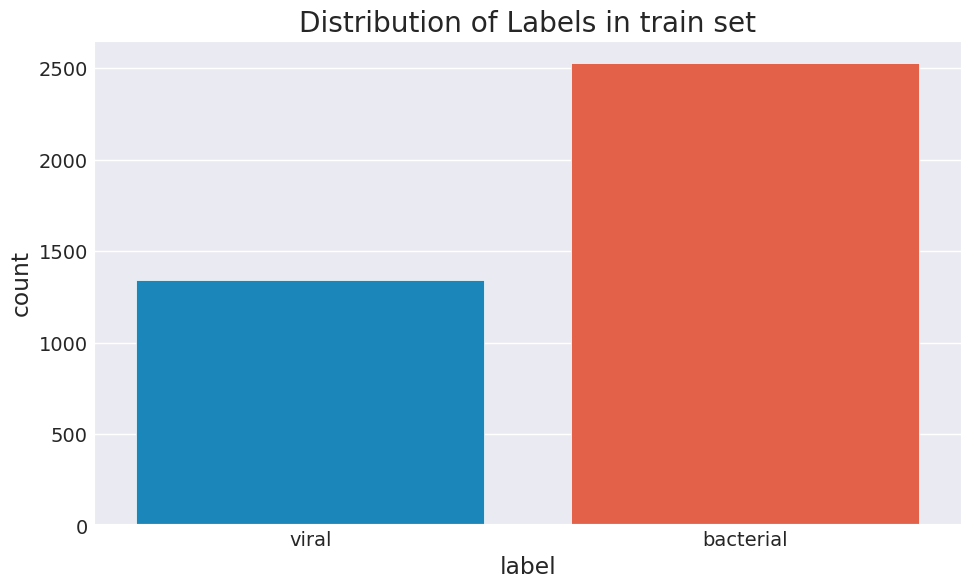

In [18]:


plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels in train set')
plt.show()


In [19]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
test_df = pd.concat([FSeries, LSeries], axis=1)
test_df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
...,...,...
385,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
386,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
387,/kaggle/input/chest-xray-pneumonia/chest_xray/...,viral
388,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial


In [20]:
# training set


data_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'

filepaths = []
labels = []

# Iterate over all files in the data path
for root, dirs, files in os.walk(data_path):
    for file in files:
        # Construct the file path
        fpath = os.path.join(root, file)
        filepaths.append(fpath)
        
        # Label the file based on the file path
        if 'bacteria' in fpath:
            labels.append('bacterial')
        elif 'virus' in fpath:
            labels.append('viral')
        else:
            labels.append('unknown')  # For file paths that do not contain 'bacteria' or 'virus'

# Create a DataFrame
FSeries = pd.Series(filepaths, name='filepaths')
LSeries = pd.Series(labels, name='label')
val_df = pd.concat([FSeries, LSeries], axis=1)
val_df

,filepaths,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
5,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
6,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial
7,/kaggle/input/chest-xray-pneumonia/chest_xray/...,bacterial


In [33]:
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=24)
valid_df, d_df = train_test_split(dummy_df, train_size=0.8, shuffle=True, random_state=12)

img_size = (224, 224)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                              color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='label', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 3100 validated image filenames belonging to 2 classes.
Found 620 validated image filenames belonging to 2 classes.
Found 390 validated image filenames belonging to 2 classes.


In [34]:
from tensorflow.keras.layers import Conv2D, Multiply, Add, Activation

def attention_block(input_tensor, filters):
    # First convolution layer
    conv1 = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    conv1 = Activation('relu')(conv1)

    # Second convolution layer
    conv2 = Conv2D(filters, (3, 3), padding='same')(conv1)
    conv2 = Activation('relu')(conv2)

    # Attention Mechanism
    attn = Add()([conv1, conv2])
    attn = Activation('relu')(attn)
    attn = Conv2D(1, (3, 3), padding='same')(attn)
    attn = Activation('softmax')(attn)

    # Multiply the input (features) with the attention map
    output_tensor = Multiply()([input_tensor, attn])

    return output_tensor

# Define the model
input_tensor = keras.Input(shape=(224, 224, 3))
x = attention_block(input_tensor, 64)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = attention_block(x, 128)

# # another layer
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2))(x)
# x = attention_block(x, 256)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)  # Added dense layer
x = Dense(64, activation='relu')(x)  # Added another dense layer
output_tensor = Dense(2, activation='softmax')(x)

model = keras.Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_gen, validation_data=valid_gen, verbose = 1, epochs=10, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(test_gen)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/10
 50/194 ━━━━━━━━━━━━━━━━━━━━ 32s 229ms/step - accuracy: 0.5449 - loss: 4.1427

2024-03-23 15:33:17.241810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.37359, expected 2.7841
2024-03-23 15:33:17.241898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.43935, expected 3.84986
2024-03-23 15:33:17.241908: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.60416, expected 4.01467
2024-03-23 15:33:17.241917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.68174, expected 4.09225
2024-03-23 15:33:17.241926: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.80871, expected 4.21922
2024-03-23 15:33:17.241935: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.51692, expected 3.92744
2024-03-23 15:33:17.241944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.75989, expected 4.1704
2024-03-23 15:33:17.241953: E external/local_xla/xla/serv

194/194 ━━━━━━━━━━━━━━━━━━━━ 69s 327ms/step - accuracy: 0.6113 - loss: 2.0019 - val_accuracy: 0.6387 - val_loss: 102.3588
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 48s 242ms/step - accuracy: 0.6853 - loss: 0.5893 - val_accuracy: 0.6274 - val_loss: 102.3899
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 48s 239ms/step - accuracy: 0.6802 - loss: 0.5896 - val_accuracy: 0.6290 - val_loss: 144.0476
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 49s 241ms/step - accuracy: 0.6905 - loss: 0.5868 - val_accuracy: 0.6339 - val_loss: 116.9377
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 49s 244ms/step - accuracy: 0.6827 - loss: 0.6015 - val_accuracy: 0.6500 - val_loss: 58.0332
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy: 0.6954 - loss: 0.5832 - val_accuracy: 0.6774 - val_loss: 29.0259
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 49s 241ms/step - accuracy: 0.7071 - loss: 0.5772 - val_accuracy: 0.6597 - val_loss: 53.5694
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 48s 238ms/step - accuracy: 0.7194 - loss: 0

W0000 00:00:1711208490.399528      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step


W0000 00:00:1711208500.597488      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       242
           1       0.86      0.69      0.76       148

    accuracy                           0.84       390
   macro avg       0.84      0.81      0.82       390
weighted avg       0.84      0.84      0.83       390



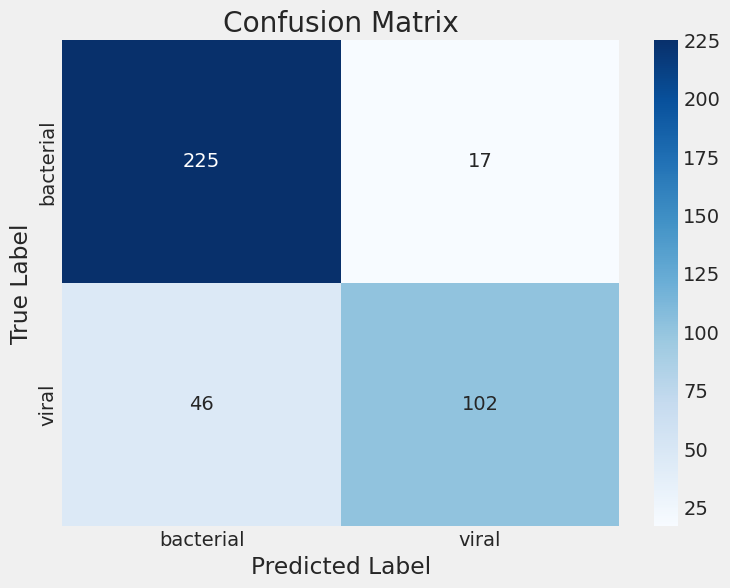

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_gen.class_indices.keys(), 
            yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

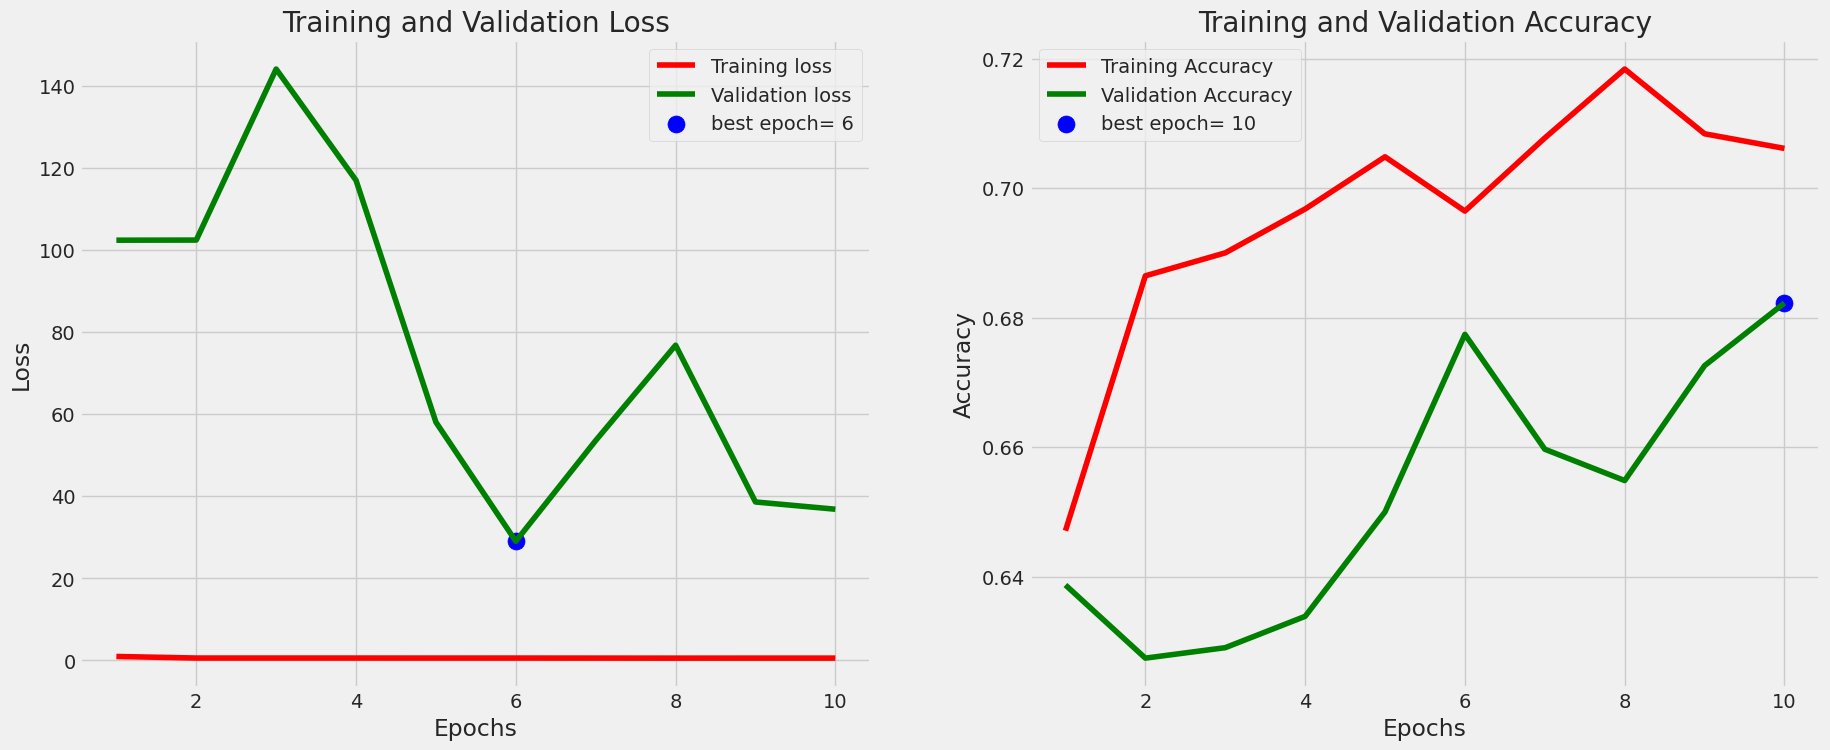

194/194 ━━━━━━━━━━━━━━━━━━━━ 44s 228ms/step - accuracy: 0.7180 - loss: 0.5713
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.7016 - loss: 31.7138
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.8211 - loss: 19.1306
Train Loss:  0.5741885900497437
Train Accuracy:  0.7122580409049988
--------------------
Validation Loss:  36.90760040283203
Validation Accuracy:  0.6822580695152283
--------------------
Test Loss:  17.691682815551758
Test Accuracy:  0.8384615182876587


In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [37]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_72 (Conv2D)  │ (None, 224, 224,  │      1,792 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_68       │ (None, 224, 224,  │          0 │ conv2d_72[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_73 (Conv2D)  │ (None, 224, 224,  │     36,928 │ activation_68[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_69       │ (None, 224, 224,  │          0 │ conv2d_73[0][0]   │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 224, 224,  │          0 │ activation_68[0]… │
│                     │ 64)               │            │ activation_69[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_70       │ (None, 224, 224,  │          0 │ add_17[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_74 (Conv2D)  │ (None, 224, 224,  │        577 │ activation_70[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_71       │ (None, 224, 224,  │          0 │ conv2d_74[0][0]   │
│ (Activation)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_17         │ (None, 224, 224,  │          0 │ input_layer_11[0… │
│ (Multiply)          │ 3)                │            │ activation_71[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 224, 224,  │      3,584 │ multiply_17[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 112, 112,  │          0 │ conv2d_75[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 112, 112,  │    147,584 │ max_pooling2d_18… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_72       │ (None, 112, 112,  │          0 │ conv2d_76[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 112, 112,  │    147,584 │ activation_72[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_73       │ (None, 112, 112,  │          0 │ conv2d_77[0][0]   │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 112, 112,  │          0 │ activation_72[0]

 Total params: 617,605,838 (2.30 GB)

 Trainable params: 205,868,612 (785.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 411,737,226 (1.53 GB)

In [38]:
# Save the model
model.save('/kaggle/working/Classfication_B_V_model.h5')

In [43]:

from tensorflow.keras.models import load_model
from PIL import Image

# Load the saved model
loaded_model = model

# Define class labels
class_labels = ["bacterial", "viral"]

# Function to preprocess the input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img = np.array(img)
    img = img / 255.0  # Normalize the image
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.repeat(img, 3, axis=-1)  # Repeat grayscale image to have 3 channels
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to make predictions
def predict_image(model, image_path):
    preprocessed_img = preprocess_image(image_path)
    prediction = model.predict(preprocessed_img)
    return prediction

# Function to get predicted class and probability
def get_predicted_class(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    probability = prediction[0][predicted_class_index]
    return predicted_class, probability

# Example usage
image_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person109_bacteria_519.jpeg'
prediction = predict_image(loaded_model, image_path)
predicted_class, probability = get_predicted_class(prediction)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Class: bacterial
Probability: 0.9150436
